In [1]:
%load_ext autoreload
%autoreload 2


In [34]:
from src.datasets import FunctionDataset, sinusoide
from torch.utils.data import DataLoader

TRAIN_SAMPLES = 1000
TEST_SAMPLES = 1000
function_range = (0, 1)
noise_level = 0.1

sinus_train_dataset = FunctionDataset(
    sinusoide, n_samples=TRAIN_SAMPLES, range=function_range, noise_std=0.1
)
sinus_test_dataset = FunctionDataset(
    sinusoide, n_samples=TEST_SAMPLES, range=function_range, noise_std=0
)

train_dataloader = DataLoader(
    sinus_train_dataset, batch_size=TRAIN_SAMPLES, shuffle=True
)
test_dataloader = DataLoader(sinus_test_dataset, batch_size=TEST_SAMPLES, shuffle=False)


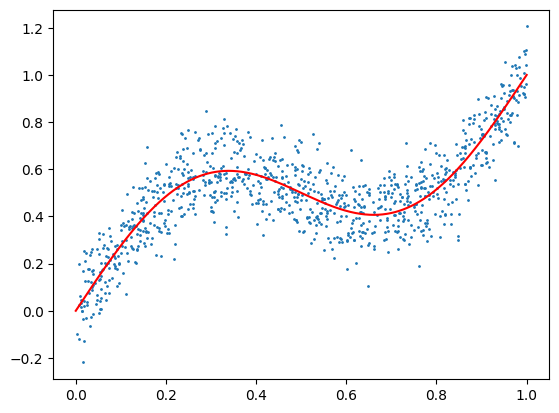

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plot_points = 1000
plt.scatter(sinus_train_dataset.x, sinus_train_dataset.y, s=1)
plt.plot(
    np.linspace(function_range[0], function_range[1], plot_points),
    sinusoide(torch.linspace(function_range[0], function_range[1], plot_points)),
    color="red",
    label="True function",
)

plt.show()


100%|██████████| 1000/1000 [00:15<00:00, 66.60it/s]


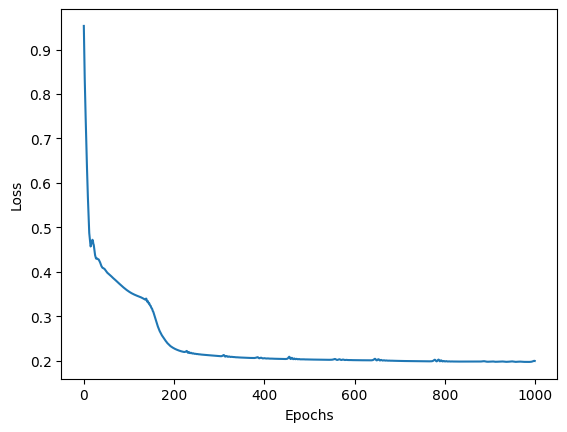

In [40]:
from src.architecture.models import LinearMDN
from src.training import train_loop, mdn_loss
from tqdm import tqdm

EPOCHS = 1000
device = "cuda" if torch.cuda.is_available() else "cpu"

mdn_model = LinearMDN(
    input_dimension=1, hidden_dims=[16], output_dimension=1, n_mixtures=5
)
mdn_model.to(device)
optimizer = torch.optim.Adam(mdn_model.parameters(), lr=0.01)

losses = []

for _ in tqdm(range(EPOCHS)):
    loss = train_loop(
        mdn_model,
        train_dataloader,
        optimizer,
        loss_function=mdn_loss,
        device=device,
    )
    losses.append(loss)

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


torch.Size([10000, 1])
torch.Size([10000])
tensor([3, 3, 3,  ..., 1, 1, 1], device='cuda:0')
torch.Size([10000, 5, 1])
torch.Size([10000, 1])


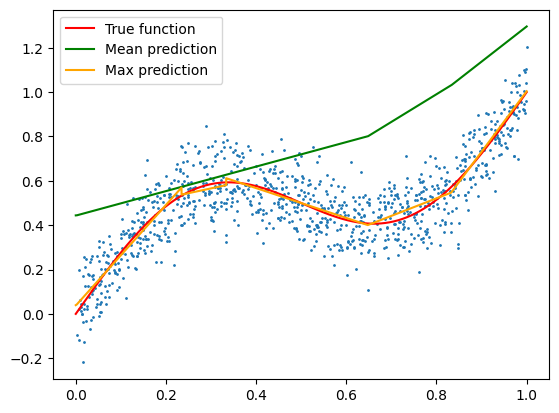

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plot_points = 10000
x = (
    torch.linspace(function_range[0], function_range[1], plot_points)
    .unsqueeze(1)
    .to(device)
)
mu, sigma, pi = mdn_model(x)

mean_mu = torch.mean(mu, dim=1)

max_mu_index = torch.argmax(pi, dim=1)

indices = torch.arange(plot_points)
max_mu = mu[indices, max_mu_index, :]


# max_mu = mu[:, max_mu_index, :]
print(max_mu.shape)

plt.scatter(sinus_train_dataset.x, sinus_train_dataset.y, s=1)
plt.plot(
    np.linspace(function_range[0], function_range[1], plot_points),
    sinusoide(torch.linspace(function_range[0], function_range[1], plot_points)),
    color="red",
    label="True function",
)
plt.plot(
    x.detach().cpu().numpy(),
    mean_mu.detach().cpu().numpy(),
    color="green",
    label="Mean prediction",
)
plt.plot(
    x.detach().cpu().numpy(),
    max_mu.detach().cpu().numpy(),
    color="orange",
    label="Max prediction",
)
plt.legend()

plt.show()
